# Predicting a Distribution with an ML Model

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from src.dataset import LazyWeatherDataset
from src.models import CNN3D
from src.loss import ShashNLL
from src.plotting import plot_distribution_heatmap
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

Severe thunderstorms and their associated hazards (wind, hail, and tornados) are sub-gridscale processes. However, they are strongly associated with the synoptic weather pattern, which is identifiable in ERA5 fields. Predict the 

Task: Predict the number of storm reports on a given day in CONUS from that day's (thinned) ERA5 data

In [2]:
# load and display data
train_data = xr.open_zarr('data/train_inputs_small.zarr').load()
test_data = xr.open_zarr('data/test_inputs_small.zarr').load()

train_targets = xr.open_dataarray('data/mdt_reports_train.nc')
test_targets = xr.open_dataarray('data/mdt_reports_test.nc')


In [3]:
train_data # gridded weather data--note that it has alread been standardized and thinned in time/space

<xarray.Dataset>
Dimensions:                       (latitude: 16, longitude: 21, day: 332,
                                   tod: 4, level: 5)
Coordinates:
  * day                           (day) datetime64[ns] 2002-04-07 ... 2019-05-20
  * latitude                      (latitude) float32 45.0 44.0 ... 31.0 30.0
  * level                         (level) int64 925 850 700 500 300
  * longitude                     (longitude) float32 255.0 256.0 ... 275.0
  * tod                           (tod) int64 0 6 12 18
Data variables: (12/13)
    10m_u_component_of_wind       (latitude, longitude, day, tod) float32 0.4...
    10m_v_component_of_wind       (latitude, longitude, day, tod) float32 -1....
    2m_dewpoint_temperature       (latitude, longitude, day, tod) float32 -0....
    2m_temperature                (latitude, longitude, day, tod) float32 -0....
    geopotential                  (level, latitude, longitude, day, tod) float32 ...
    geopotential_at_surface       (latitude, longitude, day, tod) float32 1.3...
    ...                            ...
    specific_humidity             (level, latitude, longitude, day, tod) float32 ...
    temperature                   (level, latitude, longitude, day, tod) float32 ...
    toa_incident_solar_radiation  (latitude, longitude, day, tod) float32 0.2...
    u_component_of_wind           (level, latitude, longitude, day, tod) float32 ...
    v_component_of_wind           (level, latitude, longitude, day, tod) float32 ...
    vertical_velocity             (level, latitude, longitude, day, tod) float32 ...

In [4]:
train_targets # Number of storm reports on each day

<xarray.DataArray 'REPORT_NUM' (time: 332)>
[332 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2002-04-07 2002-04-13 ... 2019-05-20

Note the skewed distribution:

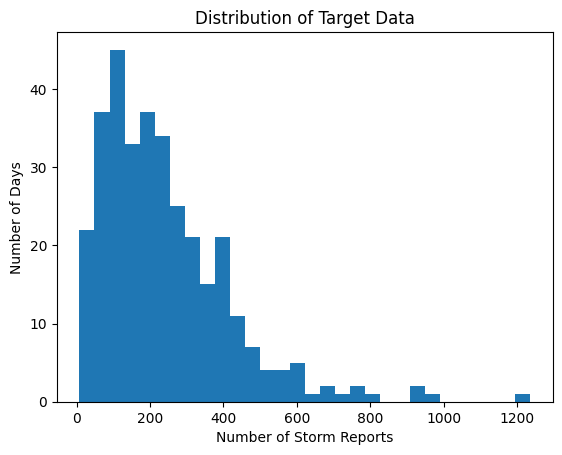

In [5]:
plt.hist(train_targets, bins = 30)
plt.xlabel('Number of Storm Reports')
plt.ylabel('Number of Days')
plt.title('Distribution of Target Data')
plt.show()

In [6]:
# We standardize the targets for stability--don't worry about this
training_mean = np.mean(train_targets).item()
training_std = np.std(train_targets).item()
train_targets = (train_targets - training_mean) / training_std
test_targets = (test_targets - training_mean) / training_std

## Setup

In [7]:
# setup
batch_size = 32

train_ds = LazyWeatherDataset(train_data, y=train_targets)
test_ds = LazyWeatherDataset(test_data, y=test_targets)

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=1)

## Traditional Regression CNN

In [8]:
train_ds[0][0].shape

torch.Size([41, 16, 21, 4])

In [9]:
train_ds[0][0].shape[0], train_ds[0][1].shape[0]

(41, 1)

Question: What do 41 and 1 represent?

Answer: 41 is the number of channels: 5 levels * 7 pressure-level fields + 6 single-level fields. 1 is the output dimension (we only want to predict one value)

### Specify Model

In [10]:
model = CNN3D(input_channels=train_ds[0][0].shape[0], output_dim=train_ds[0][1].shape[0], p_drop_conv=.3, p_drop_fc=.3)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train Model

In [11]:
# show regression model performance
epochs = 20

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 - Train Loss: 1.0574, Val Loss: 1.5323
Epoch 2/20 - Train Loss: 0.9314, Val Loss: 1.3459
Epoch 3/20 - Train Loss: 0.8328, Val Loss: 1.5336
Epoch 4/20 - Train Loss: 0.8691, Val Loss: 1.5116
Epoch 5/20 - Train Loss: 0.8344, Val Loss: 1.3172
Epoch 6/20 - Train Loss: 0.7732, Val Loss: 1.3336
Epoch 7/20 - Train Loss: 0.7855, Val Loss: 1.3424
Epoch 8/20 - Train Loss: 0.7718, Val Loss: 1.4397
Epoch 9/20 - Train Loss: 0.7932, Val Loss: 1.3720
Epoch 10/20 - Train Loss: 0.7619, Val Loss: 1.3831
Epoch 11/20 - Train Loss: 0.7465, Val Loss: 1.4552
Epoch 12/20 - Train Loss: 0.7241, Val Loss: 1.5493
Epoch 13/20 - Train Loss: 0.6827, Val Loss: 1.5515
Epoch 14/20 - Train Loss: 0.7179, Val Loss: 1.3764
Epoch 15/20 - Train Loss: 0.7192, Val Loss: 1.3755
Epoch 16/20 - Train Loss: 0.7441, Val Loss: 1.3586
Epoch 17/20 - Train Loss: 0.7086, Val Loss: 1.4427
Epoch 18/20 - Train Loss: 0.7410, Val Loss: 1.5118
Epoch 19/20 - Train Loss: 0.7001, Val Loss: 1.5028
Epoch 20/20 - Train Loss: 0.6653, Val Lo

### Display Results

Training curve and 2dhistogram of predictions vs actual

Text(0.5, 1.0, 'Training and Validation Curves')

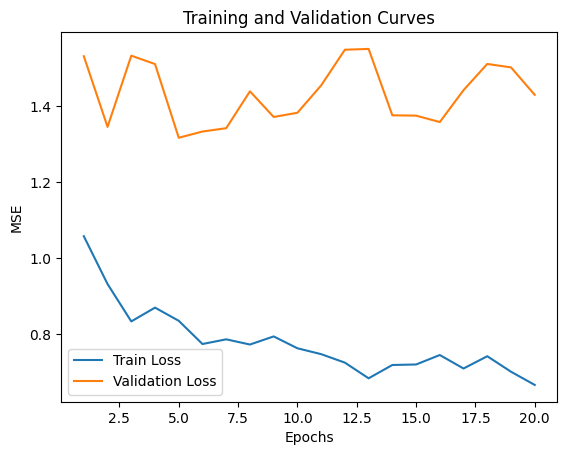

In [12]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation Curves')

Text(0, 0.5, 'Predicted Values')

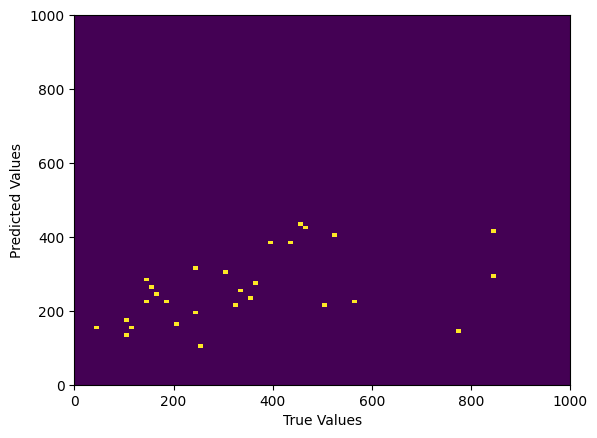

In [13]:
# make 2d historgam of test predictions vs actual
preds = []
true = []
for x, y in test_loader:
    preds.append(model(x).item() * training_std + training_mean)
    true.append(y.item() * training_std + training_mean)
plt.hist2d(true, preds, bins=100, range=[[0, 1000], [0, 1000]])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')


Question: What do you notice about the predicted values?

Answer: They positively correlate with true values, but don't ever reach the extreme high values the true values do

## Gaussian Distributional CNN

### Specify Model

In [14]:
input_channels = train_ds[0][0].shape[0] # TODO
output_dim = train_ds[0][1].shape[0] * 2 # TODO
model = CNN3D(input_channels=input_channels, output_dim=output_dim, p_drop_conv=.3, p_drop_fc=.3)

def gaussian_nll(input, target, var):
    """
    Custom Gaussian NLL that matches nn.GaussianNLLLoss.
    input: predicted mean (batch, ...)
    target: true values (batch, ...)
    var: predicted variance (batch, ...)
    """
    # TODO: Implement
    loss = 0.5 * ((target - input) ** 2 / var + torch.log(var))
    return loss.mean()
criterion = gaussian_nll

# uncomment the following line to use the built-in implementation for verification:
# criterion = nn.GaussianNLLLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Train Model

In [ ]:
# show regression model performance
epochs = 20

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)

        # TODO: HOW DO WE GET LOSS?
        # hint: use preds[0] as the mean, and preds[1] as the log(variance) (it could be just the variance, but predicting log(variance) ensures positivity)
        # then call gaussian_nll()
        mu = preds[:, 0]
        log_var = preds[:, 1]
        var = torch.exp(log_var)  # to ensure positivity
        loss = criterion(mu, y, var)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)

            # TODO: AGAIN, HOW DO WE GET LOSS?
            mu = preds[:, 0]
            log_var = preds[:, 1]
            var = torch.exp(log_var)
            loss = criterion(mu, y, var)

            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 - Train Loss: 0.5750, Val Loss: 1.2289
Epoch 2/20 - Train Loss: 0.5556, Val Loss: 1.0858
Epoch 3/20 - Train Loss: 0.5476, Val Loss: 1.0597
Epoch 4/20 - Train Loss: 0.5336, Val Loss: 1.0172
Epoch 5/20 - Train Loss: 0.5280, Val Loss: 0.9817
Epoch 6/20 - Train Loss: 0.5184, Val Loss: 0.9850
Epoch 7/20 - Train Loss: 0.5167, Val Loss: 0.9612
Epoch 8/20 - Train Loss: 0.5178, Val Loss: 0.9708
Epoch 9/20 - Train Loss: 0.5149, Val Loss: 0.9257
Epoch 10/20 - Train Loss: 0.5187, Val Loss: 0.9146
Epoch 11/20 - Train Loss: 0.5111, Val Loss: 0.9331
Epoch 12/20 - Train Loss: 0.5156, Val Loss: 0.9254
Epoch 13/20 - Train Loss: 0.5107, Val Loss: 0.9162
Epoch 14/20 - Train Loss: 0.5049, Val Loss: 0.9423
Epoch 15/20 - Train Loss: 0.5131, Val Loss: 0.9390
Epoch 16/20 - Train Loss: 0.5113, Val Loss: 0.9339
Epoch 17/20 - Train Loss: 0.5056, Val Loss: 0.9167
Epoch 18/20 - Train Loss: 0.5010, Val Loss: 0.9116
Epoch 19/20 - Train Loss: 0.5031, Val Loss: 0.9156
Epoch 20/20 - Train Loss: 0.5043, Val Lo

### Display Results

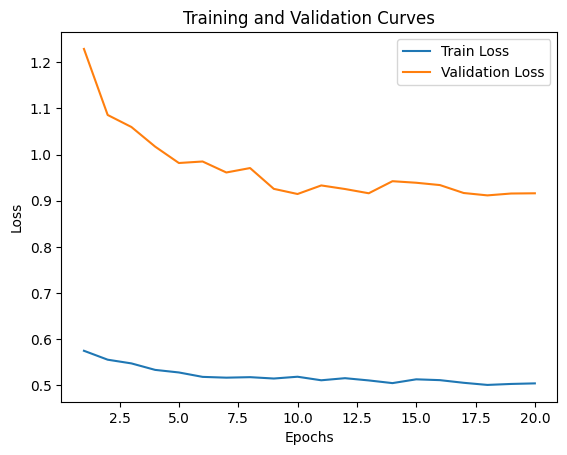

In [16]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Curves')
plt.show()

In [17]:
means = []
variances = []
true = []
for x, y in test_loader:
    means.append(model(x)[0][0].item() * training_std + training_mean)
    variances.append(model(x)[0][1].item())
    true.append(y.item() * training_std + training_mean)

gaussian_means = torch.tensor(means, dtype=torch.float32)
gaussian_variances = torch.tensor(variances, dtype=torch.float32)
gaussian_true = torch.tensor(true, dtype=torch.float32)

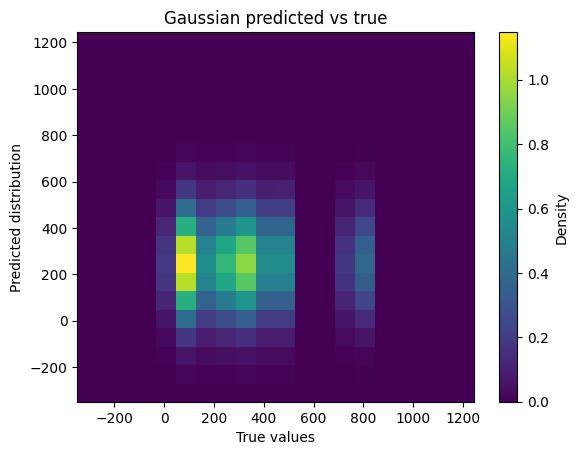

In [18]:
plot_distribution_heatmap(gaussian_true, gaussian_means, logvar=gaussian_variances, dist="gaussian", training_std = training_std, margin = .5, bins = 20)

Question: What is a flaw in the predictions?

Answer: They are symmetrical, giving nonzero probability to a negative number of reports

## SHASH Distributional CNN

### Specify Model

In [19]:
# use shash_torch.py and loss.py from barnes
input_channels = train_ds[0][0].shape[0] # TODO
output_dim = train_ds[0][1].shape[0] * 4 # TODO

model = CNN3D(input_channels=input_channels, output_dim=output_dim, p_drop_conv=.3, p_drop_fc=.3)

criterion = ShashNLL() # TODO (you don't need to implement anything--we've imported something)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def unpack_shash_params(preds):
    """
    preds: (batch, output_dim=4) tensor
    Returns: mu, sigma, gamma, tau
    """
    mu     = preds[:, 0]             # unconstrained
    sigma  = torch.exp(preds[:, 1])  # force > 0
    gamma  = preds[:, 2]             # unconstrained--add one to have model learn starting from 1 since we expect postive gamma
    tau    = torch.exp(preds[:, 3])  # force > 0
    return torch.stack([mu, sigma, gamma, tau], dim=1)

### Train Model

In [25]:
# show regression model performance
epochs = 50

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        preds = unpack_shash_params(preds)
        
        loss = criterion(preds, y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            preds = model(x)
            preds = unpack_shash_params(preds)

            loss = criterion(preds, y)

            val_loss += loss.item() * x.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50 - Train Loss: 1.2507, Val Loss: 1.5994
Epoch 2/50 - Train Loss: 1.2477, Val Loss: 1.6010
Epoch 3/50 - Train Loss: 1.2459, Val Loss: 1.6031
Epoch 4/50 - Train Loss: 1.2578, Val Loss: 1.6032
Epoch 5/50 - Train Loss: 1.2485, Val Loss: 1.5968
Epoch 6/50 - Train Loss: 1.2462, Val Loss: 1.5977
Epoch 7/50 - Train Loss: 1.2442, Val Loss: 1.6048
Epoch 8/50 - Train Loss: 1.2463, Val Loss: 1.6043
Epoch 9/50 - Train Loss: 1.2471, Val Loss: 1.6070
Epoch 10/50 - Train Loss: 1.2425, Val Loss: 1.6097
Epoch 11/50 - Train Loss: 1.2449, Val Loss: 1.6026
Epoch 12/50 - Train Loss: 1.2440, Val Loss: 1.5988
Epoch 13/50 - Train Loss: 1.2464, Val Loss: 1.5992
Epoch 14/50 - Train Loss: 1.2457, Val Loss: 1.6014
Epoch 15/50 - Train Loss: 1.2406, Val Loss: 1.5982
Epoch 16/50 - Train Loss: 1.2427, Val Loss: 1.5979
Epoch 17/50 - Train Loss: 1.2426, Val Loss: 1.5896
Epoch 18/50 - Train Loss: 1.2426, Val Loss: 1.5907
Epoch 19/50 - Train Loss: 1.2408, Val Loss: 1.5954
Epoch 20/50 - Train Loss: 1.2480, Val Lo

### Display Results

Text(0.5, 1.0, 'Training and Validation Curves')

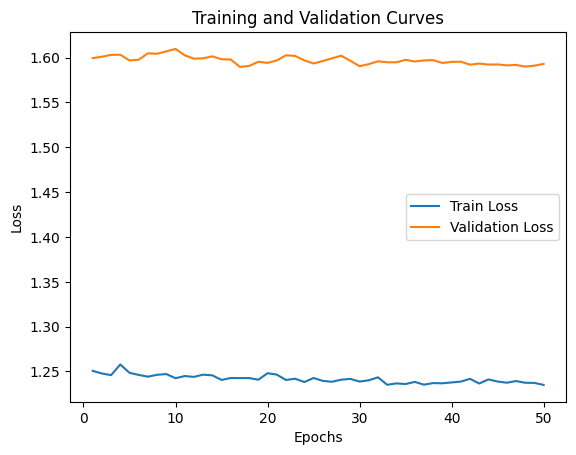

In [26]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Curves')

In [27]:
mus = []
sigmas = []
gammas = []
taus = []
true = []
for x, y in test_loader:
    mus.append(model(x)[0][0].item() * training_std + training_mean)
    sigmas.append(np.exp(model(x)[0][1].item()) * training_std)
    gammas.append(model(x)[0][2].item())
    taus.append(np.exp(model(x)[0][3].item()))
    true.append(y.item() * training_std + training_mean)

shash_mus = torch.tensor(mus, dtype=torch.float32)
shash_sigmas = torch.tensor(sigmas, dtype=torch.float32)
shash_gammas = torch.tensor(gammas, dtype=torch.float32)
shash_taus = torch.tensor(taus, dtype=torch.float32)
shash_true = torch.tensor(true, dtype=torch.float32)

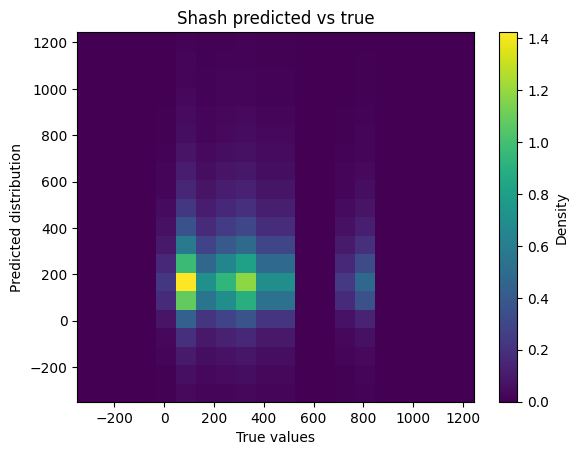

In [28]:
plot_distribution_heatmap(shash_true, shash_mus,
                          sigma=shash_sigmas, gamma=shash_gammas, tau=shash_taus,
                          dist="shash", bins = 20, margin = .5)

Question: How does this look compared to the Gaussian?

Answer: Better--it is skewed positive